# Sentiment Analysis on IMDB Data using Long-short term memory

> <i> Sentiment classification is the task of looking at a piece of text and telling if someone likes or dislikes the thing they’re talking about. </i> 
[[1](https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456)]

## IMDB Dataset
> IMDB released a adataset containing 50K reviews with their sentiment values. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. [[2](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)]

## Architecture
For this classification model, we will build a deep neural network for sentiment classification using Word embeddings. 
The model will consitst 4 differnet modules which are described in the architecture of the model is described below:<br/>
![Architecture](architeacture.png)

### Modules
> <b>Text</b><br/>
IMDB reviews dataset includes the cleaned reviews (removed symbols, lower case etc). <br/>
<br/>

> <b> Embedding Layer</b> <br/>
Word Embedding is a representation of text where words that have the same meaning have a similar representation. In other words it represents words in a coordinate system where related words, based on a corpus of relationships, are placed closer together. In the deep learning frameworks such as TensorFlow, Keras, this part is usually handled by an embedding layer which stores a lookup table to map the words represented by numeric indexes to their dense vector representations.<br/>
<br/>

> <b> Deep Network LSTM </b><br/>
Deep network takes the sequence of embedding vectors as input and converts them to a compressed representation. The compressed representation effectively captures all the information in the sequence of words in the text. The deep network part is usually an RNN or some architecture of it like LSTM/GRU. The dropout is added to overcome the tendency to overfit, which is a very common problem with RNN based networks. Please refer [here](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) for detailed discussion on LSTM,GRU.
<br/>

> <b> Fully Connected Layer </b><br/>
The fully connected layer takes the deep representation from the RNN/LSTM/GRU and transforms it into the final output classes or class scores. This component is comprised of fully connected layers along with batch normalization and optionally dropout layers for regularization. <br/>
<br/>

> <b> Output Layer </b><br/>
Based on the problem at hand, this layer can have either Sigmoid for binary classification or Softmax for both binary and multi classification output.<br/>

In [1]:
# Input Libraries
import numpy as np
import pandas as pd
import re
import string
from tqdm import tqdm
import math
import tensorflow as tf
import sklearn

In [2]:
%tensorflow_version 2.x

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [4]:
# Read dataset from data folder
dataset = pd.read_csv('/gdrive/My Drive/data/IMDB Dataset.csv')

In [5]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Data Pre-processing

In [6]:
# Label encode sentiment 
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()

dataset['sentiment'] = lb.fit_transform(dataset['sentiment'])

### Label Encoding
| Sentiment | Label 
| :- | -: 
| Positive | 1
| Negative | 0

In [7]:
# Function to remove all the html tags from test
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

In [8]:
# Function to remove all the numbers from text
def remove_numbers(text):
    text1 = re.sub(r'\d+', '', text)
    return text1

In [9]:
# Function to remove punctuations and symbols from test
def remove_symbol(text):
    for char in string.punctuation:
        text = text.replace(char,'')
    return text

In [10]:
# In this processs lets remove all symbols, html tags, numbers and lower case all the words
def clean_data(text):
  cleaned_corpus = []

  for i in tqdm(range(len(text))):
      temp = text[i] #str(dataset['review'].iloc[i])

      # remove html tage
      temp = cleanhtml(temp)

      # remove numbers
      temp = remove_numbers(temp)

      # remove punctuations
      temp = remove_symbol(temp)
      
      # remove all the numbers 
      temp1 = []
      for i in temp.split():
          if not i.isdigit():
              temp1.append(i)

      # join the list
      temp = " ".join(temp1)
      
      # convert all the words into lower case
      temp = str(temp).lower()
      
      # remove nan
      temp = [x for x in temp.split() if str(x) != 'nan']
      
      cleaned_corpus.append(" ".join(temp))
  return cleaned_corpus

In [11]:
# Call clean_data method to clean the reviews
cleaned_corpus = clean_data(dataset['review'].to_list())

100%|██████████| 50000/50000 [00:10<00:00, 4876.49it/s]


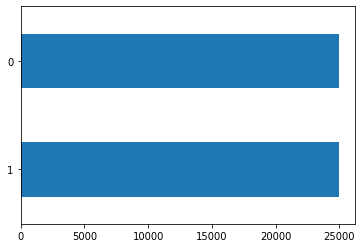

In [12]:
dataset['sentiment'].value_counts().plot(kind='barh')

### Note
> Looks like out dataset is well-balanced (Same # of review samples in both classes)

In [13]:
# Cleaning the data to remove nan(float type) from string
corpus = []
for i in cleaned_corpus:
    temp = []
    for j in i.split():
        if not j==math.nan:
            temp.append(j)
    corpus.append(" ".join(temp))
dataset['review'] = [str(i) for i in corpus]

In [14]:
# dataset_positive = dataset.loc[dataset['sentiment'] == 1]
# dataset_negative = dataset.loc[dataset['sentiment'] == 0]

In [15]:
# # Get 50% sample from original data
# dataset1 = pd.concat([dataset_positive.sample(frac=0.5, replace=False, random_state=1),dataset_negative.sample(frac=0.5, replace=False, random_state=1)])
# dataset1.head()

In [16]:
# dataset1.shape

In [17]:
# # Let's split the data into training and test data
# from sklearn.model_selection import train_test_split
# X_train, X_test,y_train, y_test = train_test_split(dataset1['review'], dataset1['sentiment'], test_size=0.25)

In [18]:
# # Checking the counts of sentiment in each test and train data
# unique, counts = np.unique(y_test, return_counts=True)
# print(unique, counts)

In [19]:
X_train = dataset.loc[:24999, 'review'].values
X_test = dataset.loc[25000:, 'review'].values
y_train = dataset.loc[:24999, 'sentiment'].values
y_test = dataset.loc[25000:, 'sentiment'].values

### Word Embeddings
> The word embeddings of our dataset can be learned while training a neural network on the classification problem. Before it can be presented to the network, the text data is first encoded so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API provided with Keras. We add padding to make all the vectors of same length (max_length). Below code converts the text to integer indexes, now ready to be used in Keras embedding layer.

In [20]:
# Function to get the length of longest review
def max_len(x):
  return len(x.split())

In [21]:
# get the max length of review column
dataset['Max Length'] = dataset['review'].apply(max_len)

In [22]:
dataset['Max Length'].max()

2441

In [23]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(lower=False, oov_token='<OOV>') # adding a OOV (Out of Vocabulary tag to identify words that are outside of corpus)
total_reviews = np.concatenate((X_train, X_test))
tokenizer.fit_on_texts(total_reviews)

max_length = dataset['Max Length'].max()

# define vocabulary size
vocabulary_size = len(tokenizer.word_index) + 1

In [24]:
vocabulary_size, max_length

(215723, 2441)

In [25]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [26]:
# Checking the length of review before and after converting to sequences
len(X_train_tokens[0]) == len(X_train[0].split())

True

In [27]:
# for x,y in zip(X_train[0].split(), X_train_tokens[0]):
#   print(x,y)

In [28]:

# Padding the sequences 
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

## Build the model

### **Gated Recurrent Unit**

| ![GRU.jpg](https://miro.medium.com/max/1050/1*jhi5uOm9PvZfmxvfaCektw.png) | 
|:--:| 
| Figure 1: GRU Cell Picture [[0](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)] |

[This](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) article is a great resource for <i> GRU vs LSTM</i>.

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
# from keras.layers.embeddings import Embedding

## GRU (Gated Recurrent Unit) model
# EMBEDDING_DIM=100
# print('Build Model..')

# model = Sequential()
# model.add(Embedding(vocabulary_size, EMBEDDING_DIM, input_length=max_length))
# model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))

# # Since this is binary classification model, lets use binary_classification as loss
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### **Global Average Pooling** 
Global average and global max pooling reduce the spatial size of the feature map/representation to one feature map for each category (classification task).

**Example:** Let's say we have an image of a cat. Global average pooling will take the average of all the actiavtion of all the activation values and tell us about the overall strength of the image, i.e. whether the image is of the cat or not. 

Global max pooling, on the other hand will take the maximum of the activation values. This will help identify the strongest trait of the image, say, ears of the dog. Similarity, in the case of textual data, global max pooling highlights the phrase with the most information while global average pooling indicates the overall value of the sentence. [[1](https://www.datasciencediscovery.com/index.php/2019/03/11/nlp-with-dl/)]

In [30]:
EMBEDDING_DIM=100

# Global Average Pooling
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocabulary_size, EMBEDDING_DIM, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

### **LSTM (Long Short Term Memory)**

LSTM has been an improvement over vanilla RNN as they are able to capture long term dependencies by introducing input, forget and output gates, which control what previous information needs to be stored and updated. [[1](https://www.datasciencediscovery.com/index.php/2019/03/11/nlp-with-dl/)]

LSTM is based on the following 3 major ideas:
* Introduing a word to allow my neural network to learn from it
* Does a previously learned word continue to make sense or should I forget about it?
* Creating the final Output that is getting the predicted value.

In [31]:
## LSTM Model 
# EMBEDDING_DIM=128

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocabulary_size, EMBEDDING_DIM, input_length=max_length),
#     tf.keras.layers.LSTM(units=60, activation='tanh'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2441, 100)         21572300  
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                2424      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 21,574,749
Trainable params: 21,574,749
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [33]:
%%time
print('Train..')

model.fit(X_train_pad, y_train, batch_size=128, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Train..
Epoch 1/25
196/196 - 35s - loss: 0.6905 - accuracy: 0.5349 - val_loss: 0.6847 - val_accuracy: 0.5058
Epoch 2/25
196/196 - 35s - loss: 0.6458 - accuracy: 0.6674 - val_loss: 0.5830 - val_accuracy: 0.7859
Epoch 3/25
196/196 - 34s - loss: 0.5046 - accuracy: 0.8046 - val_loss: 0.4510 - val_accuracy: 0.8140
Epoch 4/25
196/196 - 35s - loss: 0.3805 - accuracy: 0.8605 - val_loss: 0.3684 - val_accuracy: 0.8572
Epoch 5/25
196/196 - 34s - loss: 0.3087 - accuracy: 0.8871 - val_loss: 0.3298 - val_accuracy: 0.8706
Epoch 6/25
196/196 - 35s - loss: 0.2588 - accuracy: 0.9077 - val_loss: 0.3221 - val_accuracy: 0.8686
Epoch 7/25
196/196 - 35s - loss: 0.2245 - accuracy: 0.9220 - val_loss: 0.2897 - val_accuracy: 0.8866
Epoch 8/25
196/196 - 35s - loss: 0.1954 - accuracy: 0.9322 - val_loss: 0.2886 - val_accuracy: 0.8845
Epoch 9/25
196/196 - 35s - loss: 0.1724 - accuracy: 0.9420 - val_loss: 0.2796 - val_accuracy: 0.8920
Epoch 10/25
196/196 - 35s - loss: 0.1564 - accuracy: 0.9463 - val_loss: 0.2914 - va

### Test the Model

In [34]:
test_1 = "This movie was awesome!! I really liked it.."
test_2 = "It was really bad movie, I did not like it."
test = [test_1, test_2]
test = clean_data(test)

test_sample_token = tokenizer.texts_to_sequences(test)
test_sample_pad_seq = pad_sequences(test_sample_token, maxlen=max_length)

100%|██████████| 2/2 [00:00<00:00, 9020.01it/s]


In [35]:
# Predict the output
model.predict(x=test_sample_pad_seq)

array([[0.76446176],
       [0.24203014]], dtype=float32)

In [41]:
# Save the model to Json file
model_json = model.to_json() # De-searialize the model so that we can save in json file
with open('/gdrive/My Drive/data/IMDB_json_model.json', 'w') as fp:
  fp.write(model_json)

In [42]:
# Or you can also save the model weights to HDF5
model.save_weights('/gdrive/My Drive/data/Imdb_model_weights.h5')

In [45]:
# Or save the full model 
model.save('/gdrive/My Drive/data/IMDB_full_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /gdrive/My Drive/data/IMDB_full_model/assets


In [44]:
# Save tokenizer
import json
tokenizer_json = tokenizer.to_json()
with open('/gdrive/My Drive/data/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
